OpenGAN: Open-Set Recognition via Open Data Generation
================
**Supplemental Material for ICCV2021 Submission**


In this notebook is for demonstrating open-set semantic segmentation, especially for visualization.

import packages
------------------

Some packages are installed automatically through Anaconda. PyTorch should be also installed.

In [1]:
from __future__ import print_function, division
import os, random, time, copy, scipy, pickle, sys, math, json, pickle

import argparse, pprint, shutil, logging, time, timeit
from pathlib import Path

from skimage import io, transform
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import matplotlib.pyplot as plt
# import PIL.Image
from PIL import Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

import torch, torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
from collections import namedtuple

from config_HRNet import models
from config_HRNet import seg_hrnet
from config_HRNet import config
from config_HRNet import update_config
from config_HRNet.modelsummary  import *
from config_HRNet.utils import *


from utils.dataset_tinyimagenet import *
from utils.dataset_cityscapes import *
from utils.eval_funcs import *
from utils.model_architectures import *


import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

# %load_ext autoreload
# %autoreload 2

3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
1.4.0+cu92


Setup config parameters
 -----------------
 
 There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

In [2]:
# set the random seed
torch.manual_seed(10)


################## set attributes for this project/experiment ##################
# config result folder
exp_dir = './exp' # experiment directory, used for reading the models


device ='cpu'
if torch.cuda.is_available(): 
    device='cuda:1'
    


ganBatchSize = 1000
batch_size = 1
newsize = (-1,-1) # meaning we feed whole image to the networks

total_epoch_num = 150 # total number of epoch in training
insertConv = False    
embDimension = 64


# Number of channels in the training images. For color images this is 3
nc = 720
# Size of z latent vector (i.e. size of generator input)
nz = 64
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


lr = 0.0001 # base learning rate

num_epochs = total_epoch_num
torch.cuda.device_count()
torch.cuda.empty_cache()

save_dir = os.path.join(exp_dir, project_name)
print(save_dir)    
if not os.path.exists(save_dir): os.makedirs(save_dir)

log_filename = os.path.join(save_dir, 'train.log')

./exp/step021_GANCLS_feat4_num2000


Define model architecture of HRnet
--------- 

In [3]:
parser = argparse.ArgumentParser(description='Train segmentation network') 
parser.add_argument('--cfg',
                    help='experiment configure file name',
                    default='./config_HRNet/seg_hrnet_w48_train_512x1024_sgd_lr1e-2_wd5e-4_bs_12_epoch484.yaml',
                    type=str)
parser.add_argument('opts',
                    help="Modify config options using the command-line",
                    default=None,
                    nargs=argparse.REMAINDER)


args = parser.parse_args(r'--cfg  ./config_HRNet/seg_hrnet_w48_train_512x1024_sgd_lr1e-2_wd5e-4_bs_12_epoch484.yaml ')
args.opts = []
update_config(config, args)






model = eval(config.MODEL.NAME + '.get_seg_model_myModel')(config)
model_dict = model.state_dict()

model_state_file = '../openset/models/hrnet_w48_cityscapes_cls19_1024x2048_ohem_trainset.pth'
pretrained_dict = torch.load(model_state_file)

suppl_dict = {}
suppl_dict['last_1_conv.weight'] = pretrained_dict['model.last_layer.0.weight'].clone()
suppl_dict['last_1_conv.bias'] = pretrained_dict['model.last_layer.0.bias'].clone()

suppl_dict['last_2_BN.running_mean'] = pretrained_dict['model.last_layer.1.running_mean'].clone()
suppl_dict['last_2_BN.running_var'] = pretrained_dict['model.last_layer.1.running_var'].clone()
# suppl_dict['last_2_BN.num_batches_tracked'] = pretrained_dict['model.last_layer.1.num_batches_tracked']
suppl_dict['last_2_BN.weight'] = pretrained_dict['model.last_layer.1.weight'].clone()
suppl_dict['last_2_BN.bias'] = pretrained_dict['model.last_layer.1.bias'].clone()

suppl_dict['last_4_conv.weight'] = pretrained_dict['model.last_layer.3.weight'].clone()
suppl_dict['last_4_conv.bias'] = pretrained_dict['model.last_layer.3.bias'].clone()


pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items()
                   if k[6:] in model_dict.keys()}

model_dict.update(pretrained_dict)
model_dict.update(suppl_dict)
model.load_state_dict(model_dict)

model.eval();
model.to(device);

## Load the models of different methods

In [4]:
# we select the OpenGAN model that is trained with 2900 open training images (model selection has been done)
num_valimages = 2900
weight_adversarialLoss = 0.05
project_name = 'step030_OpenGAN_num{}_w{:.1f}'.format(num_valimages,weight_adversarialLoss)
save_dir = os.path.join(exp_dir, project_name)
bestModelIdx = 15 # we find the best model through model selection on the validation set (10 images)
path_to_D = os.path.join(save_dir, 'epoch-{}.classifier'.format(bestModelIdx+1))
OpenGANnetD2900 = DiscriminatorOpenGAN(ngpu=ngpu, nc=nc, ndf=ndf)
OpenGANnetD2900.load_state_dict(torch.load(path_to_D, map_location=lambda storage, loc: storage))
OpenGANnetD2900.eval().to(device);


# as comparison, we also read an OpenGAN-10 model (trained with only 10 open training images)
weight_adversarialLoss = 0.2
project_name = 'step030_OpenGAN_num10_w{:.1f}'.format(weight_adversarialLoss)
save_dir = os.path.join(exp_dir, project_name)
bestModelIdx = 0
path_to_D = os.path.join(save_dir, 'epoch-{}.classifier'.format(bestModelIdx+1))
OpenGANnetD10 = DiscriminatorOpenGAN(ngpu=ngpu, nc=nc, ndf=ndf)
A = torch.load(path_to_D, map_location=lambda storage, loc: storage)
OpenGANnetD10.load_state_dict(A)
OpenGANnetD10.eval().to(device);

In [5]:
# accordingly, we read a CLS-10 model (trained with only 10 open training images)
project_name = 'step008_classifierFea_v4_feat4_num10'
save_dir = os.path.join(exp_dir, project_name)
bestModelIdx = 1
path_to_D = os.path.join(save_dir, 'epoch-{}.classifier'.format(bestModelIdx+1))
CLSD10 = DiscriminatorCLS(ngpu=ngpu, nc=nc, ndf=ndf)
A = torch.load(path_to_D, map_location=lambda storage, loc: storage)
CLSD10.load_state_dict(A)
CLSD10.eval().to(device);

In [6]:
# We read a C2AE model
project_name = 'step016_C2AE_v4_feat4_try1'
bestEpoch_GAN = 20
nClass = 19
save_dir = os.path.join(exp_dir, project_name)
netC2AE = KwayCls(ngpu=ngpu, nc=nc, ndf=ndf, nClass=nClass).to(device)
path_to_D = os.path.join(save_dir, 'epoch-{}.CNet'.format(bestEpoch_GAN))
netC2AE.load_state_dict(torch.load(path_to_D))

<All keys matched successfully>

## setup of dataset


In [7]:
# torchvision.transforms.Normalize(mean, std, inplace=False)
imgTransformList = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

targetTransformList = transforms.Compose([
    transforms.ToTensor(),    
])

cls_datasets = {set_name: Cityscapes(root='./dataset/Cityscapes',
                                     newsize=newsize,
                                     split=set_name,
                                     mode='fine',
                                     target_type='semantic',
                                     transform=imgTransformList,
                                     target_transform=targetTransformList,
                                     transforms=None)
                for set_name in ['train', 'val']} # 'train', 

dataloaders = {set_name: DataLoader(cls_datasets[set_name],
                                    batch_size=batch_size,
                                    shuffle=set_name=='train', 
                                    num_workers=4) # num_work can be set to batch_size
               for set_name in ['train', 'val']} # 'train',


print(len(cls_datasets['train']), len(cls_datasets['val']))
classDictionary = cls_datasets['val'].classes

2975 500


In [8]:
id2trainID = {}
id2color = {}
trainID2color = {}
id2name = {}
opensetIDlist = []
for i in range(len(classDictionary)):
    id2trainID[i] = classDictionary[i][2]
    id2color[i] = classDictionary[i][-1]
    trainID2color[classDictionary[i][2]] = classDictionary[i][-1]
    id2name[i] = classDictionary[i][0]
    if classDictionary[i][-2]:
        opensetIDlist += [i]

id2trainID_list = []
for i in range(len(id2trainID)):
    id2trainID_list.append(id2trainID[i])
id2trainID_np = np.asarray(id2trainID_list)        
        
for elm in opensetIDlist:
    print(elm, id2name[elm])
print('total# {}'.format(len(opensetIDlist)))

0 unlabeled
1 ego vehicle
2 rectification border
3 out of roi
4 static
5 dynamic
6 ground
9 parking
10 rail track
14 guard rail
15 bridge
16 tunnel
18 polegroup
29 caravan
30 trailer
34 license plate
total# 16


testing a single image
-----------

In [9]:
data_sampler = iter(dataloaders['val'])  # the official Cityscapes val-set (500 images) is our test-set

In [10]:
data = next(data_sampler)
imageList, labelList = data[0], data[1]
imageList = imageList.to(device)
labelList = labelList.to(device)

labelList = labelList.unsqueeze(1)
labelList2show = labelList.squeeze()
labelList = F.interpolate(labelList, scale_factor=0.25, mode='nearest')
labelList = labelList.squeeze()
labelList.shape

H, W = labelList.squeeze().shape
trainlabelList = id2trainID_np[labelList.cpu().numpy().reshape(-1,).astype(np.int32)]
trainlabelList = trainlabelList.reshape((1,H,W))
trainlabelList = torch.from_numpy(trainlabelList)


trainlabelList2show = id2trainID_np[labelList2show.cpu().numpy().reshape(-1,).astype(np.int32)]
trainlabelList2show = trainlabelList2show.reshape((1,1024,2048))
trainlabelList2show = torch.from_numpy(trainlabelList2show)


print(imageList.shape, labelList.shape, trainlabelList.shape)

torch.Size([1, 3, 1024, 2048]) torch.Size([256, 512]) torch.Size([1, 256, 512])


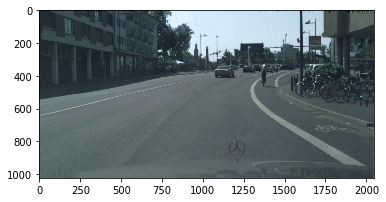

In [11]:
imageQuarterSize = F.interpolate(imageList, scale_factor=0.25, mode='nearest')
imageQuarterSize = imageQuarterSize.squeeze().detach().cpu().numpy().transpose(1,2,0)
imageQuarterSize -= imageQuarterSize.min()
imageQuarterSize /= imageQuarterSize.max()

imageList2show  = imageList.squeeze().detach().cpu().numpy().transpose(1,2,0)
imageList2show -= imageList2show.min()
imageList2show /= imageList2show.max()


plt.imshow(imageList2show)

In [12]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

upsampleFunc = nn.UpsamplingBilinear2d(scale_factor=4)
with torch.no_grad():
    imageList = imageList.to(device)
    logitsTensor = model(imageList).detach().cpu()
    #logitsTensor = upsampleFunc(logitsTensor)
    pixConf_SoftMax = F.softmax(logitsTensor, dim=1)   
    pixConf_Entropy = myEntropy(pixConf_SoftMax, 1)
    pixConf_SoftMax = pixConf_SoftMax.max(1, keepdim=False)[0]
    
    feat1Tensor = model.feat1.detach()
    feat2Tensor = model.feat2.detach()
    feat3Tensor = model.feat3.detach()
    feat4Tensor = model.feat4.detach()
    feat5Tensor = model.feat5.detach()
    torch.cuda.empty_cache()
    
    
    
allPixList = feat4Tensor.squeeze()
allPixList = allPixList.reshape(allPixList.shape[0], -1).permute(1,0).unsqueeze(-1).unsqueeze(-1).to(device)
with torch.no_grad():
    pixConf_OpenGAN2900 = OpenGANnetD2900(allPixList) #.view(-1)
    pixConf_OpenGAN10 = OpenGANnetD10(allPixList) #.view(-1)
    pixConf_CLS10 = CLSD10(allPixList) #.view(-1)    
    pixConf_C2AE = netC2AE(allPixList)
    
pixConf_SoftMax = pixConf_SoftMax.reshape(256, 512).detach().cpu().numpy()
pixConf_Entropy = pixConf_Entropy.reshape(256, 512).detach().cpu().numpy()
pixConf_C2AE = pixConf_C2AE.reshape(256, 512).detach().cpu().numpy()

pixConf_OpenGAN2900 = pixConf_OpenGAN2900.reshape(256, 512).detach().cpu().numpy()
pixConf_OpenGAN10 = pixConf_OpenGAN10.reshape(256, 512).detach().cpu().numpy()
pixConf_CLS10 = pixConf_CLS10.reshape(256, 512).detach().cpu().numpy()

pixLabel = ((trainlabelList>=0) & (trainlabelList<=18)).type(torch.float).unsqueeze(0).to(device)
segMap = label_to_color(labelList2show.cpu().numpy().squeeze(), id2color)

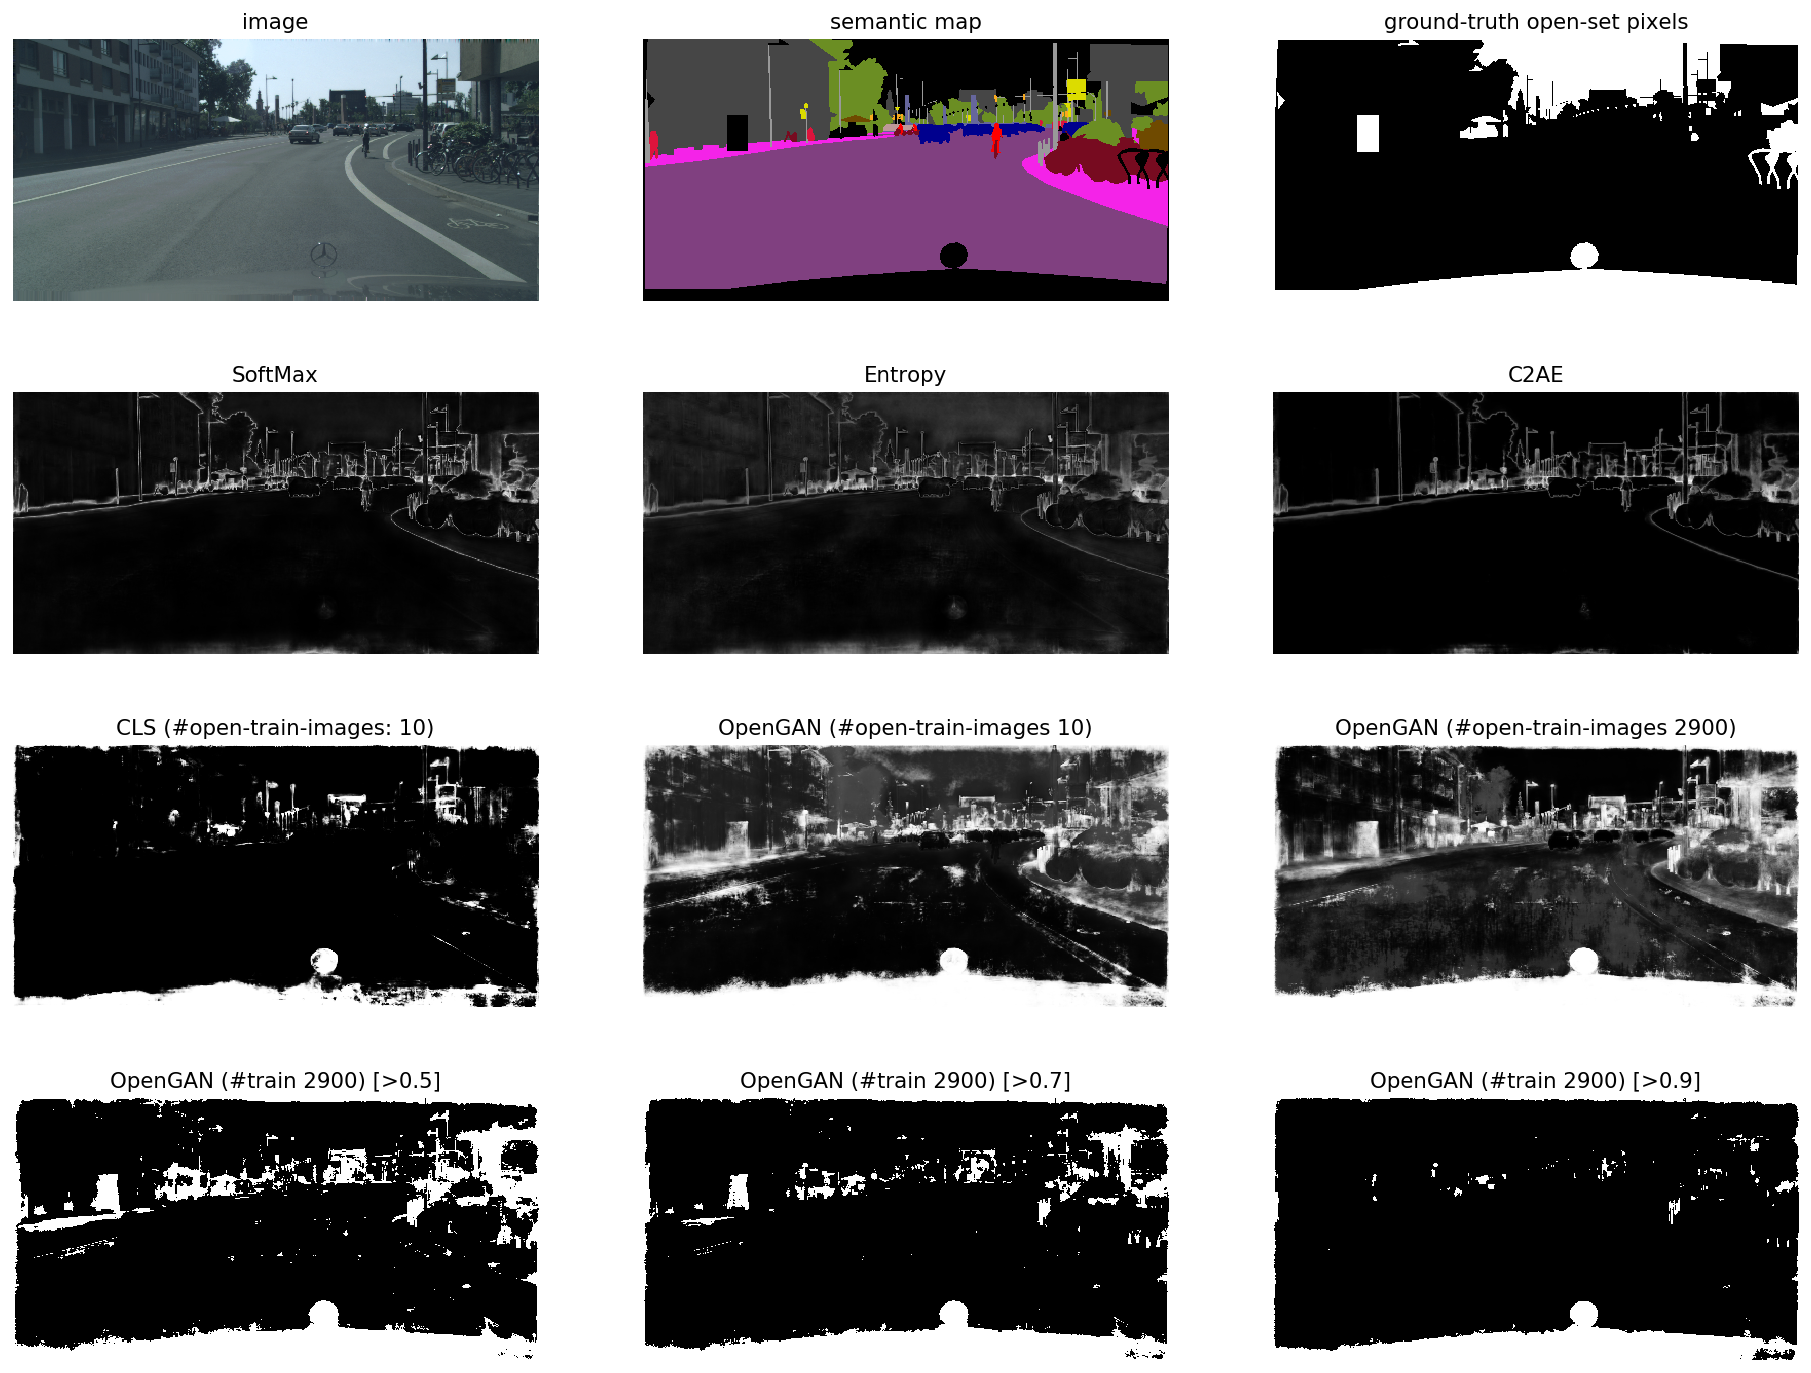

In [13]:
if True:  # We visualize the results 
    figWinNumHeight, figWinNumWidth = 4, 3
    plt.figure(figsize=(18,14), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch

    plt.clf()
    subwinCount = 1
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    plt.imshow(imageList2show)
    plt.axis('off')
    plt.title('image')

    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    plt.imshow(segMap.astype(np.uint8))
    plt.axis('off')
    plt.title('semantic map')

    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    plt.imshow(1-pixLabel.squeeze().detach().cpu(), cmap='gray')
    plt.axis('off')
    plt.title('ground-truth open-set pixels')
    
    
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    TMP = pixConf_SoftMax
    TMP -= TMP.min()
    TMP /= TMP.max() 
    plt.imshow(1-TMP, cmap='gray')
    plt.axis('off')
    plt.title('SoftMax')

    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    TMP = pixConf_Entropy
    TMP -= TMP.min()
    TMP /= TMP.max()    
    plt.imshow(TMP, cmap='gray')
    plt.axis('off')
    plt.title('Entropy')
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    TMP = pixConf_C2AE
    TMP -= TMP.min()
    TMP /= TMP.max()    
    plt.imshow(TMP, cmap='gray')
    plt.axis('off')
    plt.title('C2AE')
    
    
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    TMP = pixConf_CLS10
    TMP -= TMP.min()
    TMP /= TMP.max()    
    plt.imshow(1-TMP, cmap='gray')
    plt.axis('off')
    plt.title('CLS (#open-train-images: 10)')

    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    TMP = pixConf_OpenGAN10
    TMP -= TMP.min()
    TMP /= TMP.max()    
    plt.imshow(1-TMP, cmap='gray')
    plt.axis('off')
    plt.title('OpenGAN (#open-train-images 10)')
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    TMP = pixConf_OpenGAN2900
    TMP -= TMP.min()
    TMP /= TMP.max()  
    plt.imshow(1-TMP, cmap='gray')
    plt.axis('off')
    plt.title('OpenGAN (#open-train-images 2900)')
    
    
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    TMP = pixConf_OpenGAN2900
    TMP -= TMP.min()
    TMP /= TMP.max()  
    TMP = (1-TMP)>0.5
    plt.imshow(TMP, cmap='gray')
    plt.axis('off')
    plt.title('OpenGAN (#train 2900) [>0.5]')
        
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    TMP = pixConf_OpenGAN2900
    TMP -= TMP.min()
    TMP /= TMP.max()  
    TMP = (1-TMP)>0.7
    plt.imshow(TMP, cmap='gray')
    plt.axis('off')
    plt.title('OpenGAN (#train 2900) [>0.7]')
        
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    TMP = pixConf_OpenGAN2900
    TMP -= TMP.min()
    TMP /= TMP.max()  
    TMP = (1-TMP)>0.9
    plt.imshow(TMP, cmap='gray')
    plt.axis('off')
    plt.title('OpenGAN (#train 2900) [>0.9]')

## Generating all the visual result on the 500 testing images

0/500
1/500
2/500
3/500
4/500
5/500
6/500
7/500
8/500
9/500
10/500
11/500
12/500
13/500
14/500
15/500
16/500
17/500
18/500
19/500
20/500
21/500
22/500
23/500
24/500
25/500
26/500
27/500
28/500
29/500
30/500
31/500
32/500
33/500
34/500
35/500
36/500
37/500
38/500
39/500
40/500
41/500
42/500
43/500
44/500
45/500
46/500
47/500
48/500
49/500
50/500
51/500
52/500
53/500
54/500
55/500
56/500
57/500
58/500
59/500
60/500
61/500
62/500
63/500
64/500
65/500
66/500
67/500
68/500
69/500
70/500
71/500
72/500
73/500
74/500
75/500
76/500
77/500
78/500
79/500
80/500
81/500
82/500
83/500
84/500
85/500
86/500
87/500
88/500
89/500
90/500
91/500
92/500
93/500
94/500
95/500
96/500
97/500
98/500
99/500
100/500
101/500
102/500
103/500
104/500
105/500
106/500
107/500
108/500
109/500
110/500
111/500
112/500
113/500
114/500
115/500
116/500
117/500
118/500
119/500
120/500
121/500
122/500
123/500
124/500
125/500
126/500
127/500
128/500
129/500
130/500
131/500
132/500
133/500
134/500
135/500
136/500
137/500
138/50

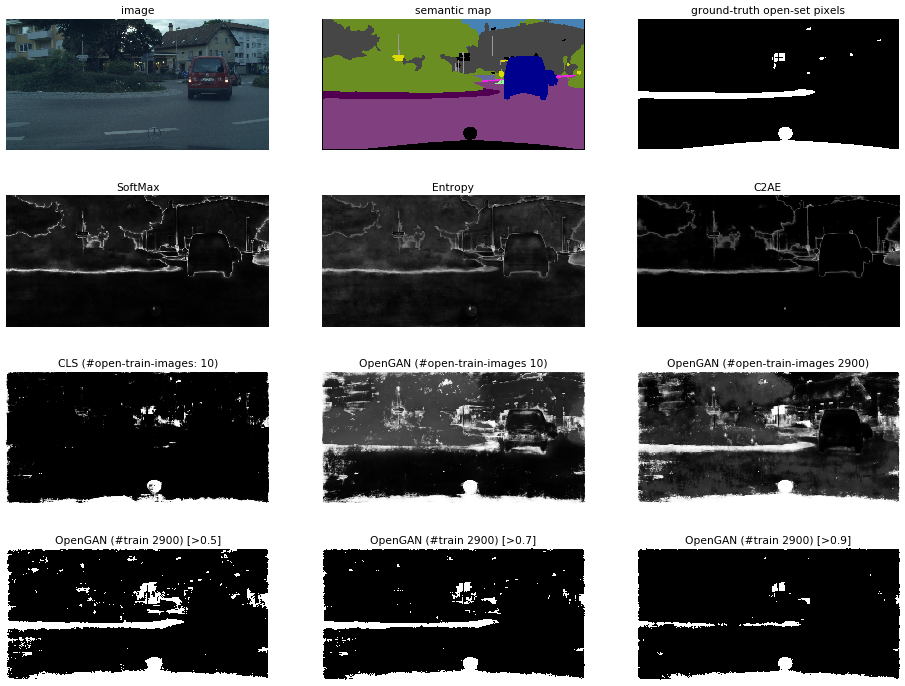

In [14]:
figWinNumHeight, figWinNumWidth = 4, 3
plt.figure(figsize=(18,14), dpi=64, facecolor='w', edgecolor='k') # figsize -- inch-by-inch

path_to_save_visual = './visualFolder_valset'
if not os.path.exists(path_to_save_visual): 
    os.makedirs(path_to_save_visual)


idx = -1
for sample in dataloaders['val']:
    idx += 1
    
    #if idx not in valImgList: 
    #    continue
    
    print('{}/{}'.format(idx, len(dataloaders['val'])))
    
    
    imageList, labelList = sample
    imageList = imageList.to(device)
    labelList = labelList.to(device)

    labelList = labelList.unsqueeze(1)
    labelList2show = labelList.squeeze()
    labelList = F.interpolate(labelList, scale_factor=0.25, mode='nearest')
    labelList = labelList.squeeze()
    labelList.shape

    H, W = labelList.squeeze().shape
    trainlabelList = id2trainID_np[labelList.cpu().numpy().reshape(-1,).astype(np.int32)]
    trainlabelList = trainlabelList.reshape((1,H,W))
    trainlabelList = torch.from_numpy(trainlabelList)

    trainlabelList2show = id2trainID_np[labelList2show.cpu().numpy().reshape(-1,).astype(np.int32)]
    trainlabelList2show = trainlabelList2show.reshape((1,1024,2048))
    trainlabelList2show = torch.from_numpy(trainlabelList2show)

    with torch.no_grad():
        imageList = imageList.to(device)
        logitsTensor = model(imageList).detach().cpu()
        #logitsTensor = upsampleFunc(logitsTensor)
        pixConf_SoftMax = F.softmax(logitsTensor, dim=1)   
        pixConf_Entropy = myEntropy(pixConf_SoftMax, 1)
        pixConf_SoftMax = pixConf_SoftMax.max(1, keepdim=False)[0]

        feat1Tensor = model.feat1.detach()
        feat2Tensor = model.feat2.detach()
        feat3Tensor = model.feat3.detach()
        feat4Tensor = model.feat4.detach()
        feat5Tensor = model.feat5.detach()
        torch.cuda.empty_cache()

        
    allPixList = feat4Tensor.squeeze()
    allPixList = allPixList.reshape(allPixList.shape[0], -1).permute(1,0).unsqueeze(-1).unsqueeze(-1).to(device)
    with torch.no_grad():
        pixConf_OpenGAN2900 = OpenGANnetD2900(allPixList) #.view(-1)
        pixConf_OpenGAN10 = OpenGANnetD10(allPixList) #.view(-1)
        pixConf_CLS10 = CLSD10(allPixList) #.view(-1)

        pixConf_C2AE = netC2AE(allPixList)
        pixConf_C2AE = F.softmax(pixConf_C2AE, dim=1)
        pixConf_C2AE = myEntropy(pixConf_C2AE, 1)




    pixConf_SoftMax = pixConf_SoftMax.reshape(256, 512).detach().cpu().numpy()
    pixConf_Entropy = pixConf_Entropy.reshape(256, 512).detach().cpu().numpy()
    pixConf_C2AE = pixConf_C2AE.reshape(256, 512).detach().cpu().numpy()

    pixConf_OpenGAN2900 = pixConf_OpenGAN2900.reshape(256, 512).detach().cpu().numpy()
    pixConf_OpenGAN10 = pixConf_OpenGAN10.reshape(256, 512).detach().cpu().numpy()
    pixConf_CLS10 = pixConf_CLS10.reshape(256, 512).detach().cpu().numpy()
    
    
    
    imageList2show  = imageList.squeeze().detach().cpu().numpy().transpose(1,2,0)
    imageList2show -= imageList2show.min()
    imageList2show /= imageList2show.max()

    pixLabel = ((trainlabelList>=0) & (trainlabelList<=18)).type(torch.float).unsqueeze(0).to(device)
    segMap = label_to_color(labelList2show.cpu().numpy().squeeze(), id2color)
    

    plt.clf()
    subwinCount = 1
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    plt.imshow(imageList2show)
    plt.axis('off')
    plt.title('image')

    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    plt.imshow(segMap.astype(np.uint8))
    plt.axis('off')
    plt.title('semantic map')

    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    plt.imshow(1-pixLabel.squeeze().detach().cpu(), cmap='gray')
    plt.axis('off')
    plt.title('ground-truth open-set pixels')
    
    
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    TMP = pixConf_SoftMax
    TMP -= TMP.min()
    TMP /= TMP.max() 
    plt.imshow(1-TMP, cmap='gray')
    plt.axis('off')
    plt.title('SoftMax')

    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    TMP = pixConf_Entropy
    TMP -= TMP.min()
    TMP /= TMP.max()    
    plt.imshow(TMP, cmap='gray')
    plt.axis('off')
    plt.title('Entropy')
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    TMP = pixConf_C2AE
    TMP -= TMP.min()
    TMP /= TMP.max()    
    plt.imshow(TMP, cmap='gray')
    plt.axis('off')
    plt.title('C2AE')
    
    
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    TMP = pixConf_CLS10
    TMP -= TMP.min()
    TMP /= TMP.max()    
    plt.imshow(1-TMP, cmap='gray')
    plt.axis('off')
    plt.title('CLS (#open-train-images: 10)')

    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    TMP = pixConf_OpenGAN10
    TMP -= TMP.min()
    TMP /= TMP.max()    
    plt.imshow(1-TMP, cmap='gray')
    plt.axis('off')
    plt.title('OpenGAN (#open-train-images 10)')
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    TMP = pixConf_OpenGAN2900
    TMP -= TMP.min()
    TMP /= TMP.max()  
    plt.imshow(1-TMP, cmap='gray')
    plt.axis('off')
    plt.title('OpenGAN (#open-train-images 2900)')
    
    
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    TMP = pixConf_OpenGAN2900
    TMP -= TMP.min()
    TMP /= TMP.max()  
    TMP = (1-TMP)>0.5
    plt.imshow(TMP, cmap='gray')
    plt.axis('off')
    plt.title('OpenGAN (#train 2900) [>0.5]')
        
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    TMP = pixConf_OpenGAN2900
    TMP -= TMP.min()
    TMP /= TMP.max()  
    TMP = (1-TMP)>0.7
    plt.imshow(TMP, cmap='gray')
    plt.axis('off')
    plt.title('OpenGAN (#train 2900) [>0.7]')
        
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    TMP = pixConf_OpenGAN2900
    TMP -= TMP.min()
    TMP /= TMP.max()  
    TMP = (1-TMP)>0.9
    plt.imshow(TMP, cmap='gray')
    plt.axis('off')
    plt.title('OpenGAN (#train 2900) [>0.9]')
    
    
    plt.savefig(path.join(path_to_save_visual, '{:03d}.png'.format(idx)))